In [158]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import prepState
from numpy import linalg as LA
from timeEvo import *
#from generateStates import *
from qutip import *

# for using tex formatting and font in plots
#"""
plt.rcParams.update({"text.usetex": True,}) 
#mpl.rcParams['text.latex.preamble'] = [r'\usepackage[utf8]{inputenc}\usepackage[T1]{fontenc}\usepackage{lmodern}\inputencoding{utf8}\usepackage{amsmath}\usepackage{amssymb}\usepackage{dsfont}\usepackage{mathtools}\usepackage{physics}']
mpl.rcParams['font.family'] = ['serif']
#"""

In [159]:
## a lot of functions
#
def generateStates(N):
    myStates = {}
    myBasis = {}
    for i in range(N+1):
        myStates["sigmaX", i] = prepState.stateX(N,i)
        myStates["sigmaY", i] = prepState.stateY(N,i)
        myStates["sigmaZ", i] = prepState.stateZ(N,i)
        myBasis["zero",i] = prepState.state0(N,i)
        myBasis["one",i] = prepState.state1(N,i)

    l = 1

    Hint = 0
    for i in range(N): # interaction hamiltonian, XY-Heisenberg
        Hint = Hint + l / 2 * np.sqrt((i+1)*(N-i)) * (myStates["sigmaX", i] * myStates["sigmaX", i+1] + myStates["sigmaY", i] * myStates["sigmaY", i+1])
    J = 1/2
    Hint = J * Hint # change interaction strength 

    H0 = 0
    for i in range(1,N+1):
            H0 = H0 - myStates["sigmaZ", i]

    return Hint


def generateRho(beta):
    rho = (-beta * sigmaz()).expm()
    Z = rho.tr()
    rho = rho/Z
    return rho


def timeEvo(dt, rho, Hint): # time evolution of an operator rho, SE approach as opposed to me approach
	U = (-1.j * Hint * dt).expm()
	Ud = (1.j * Hint * dt).expm()
	rho = rho * Ud
	return U * rho


def initSystem(alpha, firstState, secondState, N):
	astar = -alpha
	rhoSystem = tensor(firstState, secondState)+ alpha * tensor(Qobj([[0,1],[0,0]]), Qobj([[0,0],[1,0]])) + astar * tensor(Qobj([[0,0],[1,0]]), Qobj([[0,1],[0,0]]))
	for i in range(1,N):
		rhoSystem = tensor(rhoSystem, Qobj([[0,0],[0,1]]))
	return rhoSystem


In [160]:
## define plot parameters
#
# this is not really for anything, just for me to copy paste
def plotOne(ylabel,howmany,what,title):
    fig, ax = plt.subplots()
    for i in howmany:
        ax.plot(t, what, label="F(t)")#, '+')
    ax.set_title(title)
    ax.set_xlabel("time")
    ax.set_ylabel(ylabel)
    ax.axvline(np.pi,color='grey')
    ax.axhline(1,color='grey')
    plt.show(block=True)

In [161]:
## define constants
#
N=4
betaOne = 1
betaTwo = .1 *.1*.1
#alpha = 1.j * .25 * 1/(np.cosh(beta))**2
#astar = -alpha
n = 3200
dt = 1e-3
t = np.linspace(0, n*dt, n)

In [162]:
## initiate States
#
firstState = generateRho(betaOne)
secondState = generateRho(betaTwo)

alpha = 1j* 1/((-betaOne * sigmaz()).expm().tr()) * 1/((-betaTwo * sigmaz()).expm().tr()) * np.exp(-(betaOne + betaTwo)/2)
#alpha = 1.j * .25 * 1/(np.cosh(beta))**2

rhoSystem = initSystem(alpha, firstState, secondState, N)
rhoSystempoint5 = initSystem(.5*alpha, firstState, secondState, N)
rhoSystempoint1 = initSystem(.1*alpha, firstState, secondState, N)
rhoSystemzero = initSystem(0, firstState, secondState, N)


Hint = generateStates(N)

#qResult = qutip.mesolve(Hint, initSystem, t, [], []).states # mesolve = master equation approach
#myResult = [timeEvo(dt, initSystem, Hint) for dt in t]

In [163]:
## calculate time evolution
#
maxEvo = qutip.mesolve(Hint, rhoSystem, t, [], []).states
point5Evo = qutip.mesolve(Hint, rhoSystempoint5, t, [], []).states
point1Evo = qutip.mesolve(Hint, rhoSystempoint1, t, [], []).states
zeroEvo = qutip.mesolve(Hint, rhoSystemzero, t, [], []).states

In [164]:
## a shitton of quantities, the lists are always the values as a function of t
#
"""
myFidelity = [fidelity(firstState, myResult[i].ptrace(N).unit()) for i in range(0,n+1)]
qEnt = [entropy_vn(timeEvo(dt, initSystem, Hint).ptrace(N), base=np.e) for dt in t]
myInfoflow = np.diff(qEnt)/dt
myHeatlim = [-1.j *(np.pi/3 *1 / (np.log(2)**2)) * (commutator(timeEvo(dt, initSystem, Hint), Hint).unit().ptrace(N) * sigmaz()).tr() for dt in t]
myKLdiv = [entropy_relative(firstState.unit(), timeEvo(dt, initSystem, Hint).ptrace(N)) for dt in t]
myHeatflow = [-1.j * (commutator(timeEvo(dt, initSystem, Hint), Hint).unit().ptrace(N) * sigmaz()).tr() for dt in t]
myInfoflow2 = [myInfoflow[n]**2 for n in range(len(myInfoflow))]
"""

'\nmyFidelity = [fidelity(firstState, myResult[i].ptrace(N).unit()) for i in range(0,n+1)]\nqEnt = [entropy_vn(timeEvo(dt, initSystem, Hint).ptrace(N), base=np.e) for dt in t]\nmyInfoflow = np.diff(qEnt)/dt\nmyHeatlim = [-1.j *(np.pi/3 *1 / (np.log(2)**2)) * (commutator(timeEvo(dt, initSystem, Hint), Hint).unit().ptrace(N) * sigmaz()).tr() for dt in t]\nmyKLdiv = [entropy_relative(firstState.unit(), timeEvo(dt, initSystem, Hint).ptrace(N)) for dt in t]\nmyHeatflow = [-1.j * (commutator(timeEvo(dt, initSystem, Hint), Hint).unit().ptrace(N) * sigmaz()).tr() for dt in t]\nmyInfoflow2 = [myInfoflow[n]**2 for n in range(len(myInfoflow))]\n'

In [165]:
## stuff that is new in main.py
#

qEntmax = [entropy_vn(maxEvo[dt].ptrace(N), base=np.e) for dt in range(len(t))]
qEntpoint5 = [entropy_vn(point5Evo[dt].ptrace(N), base=np.e) for dt in range(len(t))]
qEntpoint1 = [entropy_vn(point1Evo[dt].ptrace(N), base=np.e) for dt in range(len(t))]
qEntzero = [entropy_vn(zeroEvo[dt].ptrace(N), base=np.e) for dt in range(len(t))]
print('#')
infoFlowmax = np.square(np.diff(qEntmax)/t[1])
infoFlowpoint5 = np.square(np.diff(qEntpoint5)/t[1])
infoFlowpoint1 = np.square(np.diff(qEntpoint1)/t[1])
infoFlowzero = np.square(np.diff(qEntzero)/t[1])
print('##')
maxHeatlim = [-1.j *(np.pi/3 *1 / (np.log(2)**2)) * (commutator(Hint, maxEvo[dt]).ptrace(N) * sigmaz()).tr() for dt in range(len(t))]
point5Heatlim = [-1.j *(np.pi/3 *1 / (np.log(2)**2)) * (commutator(Hint, point5Evo[dt]).ptrace(N) * sigmaz()).tr() for dt in range(len(t))]
point1Heatlim = [-1.j *(np.pi/3 *1 / (np.log(2)**2)) * (commutator(Hint, point1Evo[dt]).ptrace(N) * sigmaz()).tr() for dt in range(len(t))]
zeroHeatlim = [-1.j *(np.pi/3 *1 / (np.log(2)**2)) * (commutator(Hint, zeroEvo[dt]).ptrace(N) * sigmaz()).tr() for dt in range(len(t))]
print('###')
maxFid = [fidelity(firstState, maxEvo[dt].ptrace(N)) for dt in range(len(t))]
point5Fid = [fidelity(firstState, point5Evo[dt].ptrace(N)) for dt in range(len(t))]
point1Fid = [fidelity(firstState, point1Evo[dt].ptrace(N)) for dt in range(len(t))]
zeroFid = [fidelity(firstState, zeroEvo[dt].ptrace(N)) for dt in range(len(t))]
print('####')
magnet_max_first = [expect(maxEvo[dt].ptrace(0), sigmaz()) for dt in range(len(t))]
magnet_max_last = [expect(maxEvo[dt].ptrace(N), sigmaz()) for dt in range(len(t))]
#magnet_point1 = [expect(point1Evo[dt].ptrace(N), sigmaz()) for dt in range(len(t))]
#magnet_zero = [expect(zeroEvo[dt].ptrace(N), sigmaz()) for dt in range(len(t))]


#
##
###
####


-
--
---
----


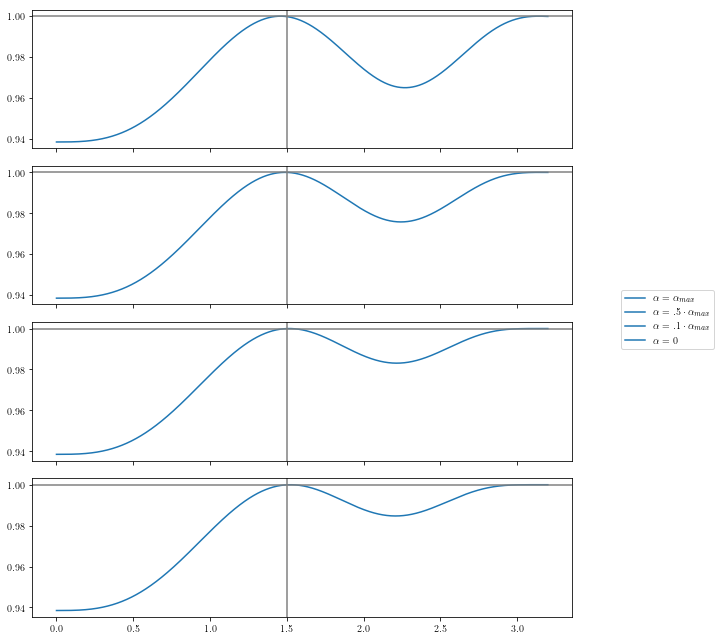

In [170]:
fig, (axs1, axs2, axs3, axs4) = plt.subplots(4,1,sharex=True, sharey=True, figsize=(10,9))


axs1.plot(t, maxFid, label=r"$\alpha = \alpha_{max}$")
print('-')
axs2.plot(t, point5Fid, label=r"$\alpha = .5 \cdot \alpha_{max}$")
print('--')
axs3.plot(t, point1Fid, label=r"$\alpha = .1 \cdot \alpha_{max}$")
print('---')
axs4.plot(t, zeroFid, label=r"$\alpha = 0$")
print('----')

axs1.axhline(1,color='grey')
axs2.axhline(1,color='grey')
axs3.axhline(1,color='grey')
axs4.axhline(1,color='grey')


axs1.axvline(1.5,color='grey')
axs2.axvline(1.5,color='grey')
axs3.axvline(1.5,color='grey')
axs4.axvline(1.5,color='grey')

fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.8)

#plt.savefig("fidelity_very_diff_temp.pdf")
plt.show()

####
-
--
---
----


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1365: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


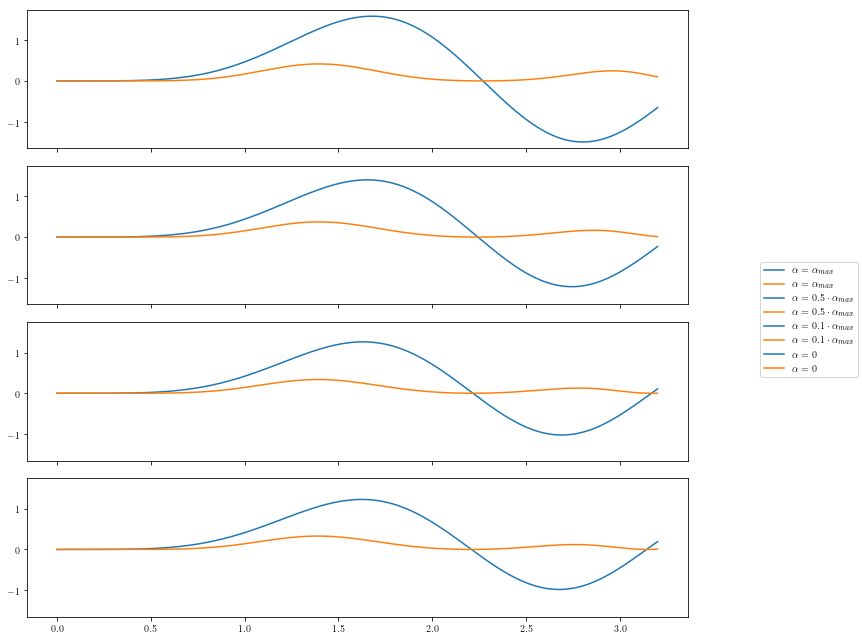

In [167]:




fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,sharex=True, sharey=True, figsize=(12,9))
print('####')

ax1.plot(t, maxHeatlim, label=r"$\alpha = \alpha_{max}$")
ax1.plot(t[:-1], infoFlowmax, label=r"$\alpha = \alpha_{max}$")
print('-')
ax2.plot(t, point5Heatlim, label=r"$\alpha = 0.5 \cdot \alpha_{max}$")
ax2.plot(t[:-1], infoFlowpoint5, label=r"$\alpha = 0.5 \cdot \alpha_{max}$")
print('--')
ax3.plot(t, point1Heatlim, label=r"$\alpha = 0.1 \cdot \alpha_{max}$")
ax3.plot(t[:-1], infoFlowpoint1, label=r"$\alpha = 0.1 \cdot \alpha_{max}$")
print('---')
ax4.plot(t, zeroHeatlim, label=r"$\alpha = 0$")
ax4.plot(t[:-1], infoFlowzero, label=r"$\alpha = 0$")
print('----')

#ax1.axhline(0,color='grey')
#ax2.axhline(0,color='grey')
#ax3.axhline(0,color='grey')


fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.8)

#plt.savefig("testplot.pdf")
plt.show()

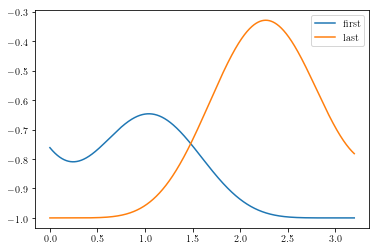

In [168]:
plt.plot(t, magnet_max_first, label=r"first")
plt.plot(t, magnet_max_last, label=r"last")
plt.legend()
plt.show()

In [169]:
## plots
#

"""fig, (ax2, ax3) = plt.subplots(2,1,sharex=True, figsize=(12,9))
cmap = mpl.cm.get_cmap()

ax3.plot(t[:-1], myInfoflow2, color=cmap(1/3), label="$\dot{\mathcal{I}}_N^2$")
ax3.plot(t, myHeatlim, color = cmap(2/3), label="$\dot{E}_N\pi/(3\ln^2(2))$")
ax2.plot(t, myHeatflow, color = cmap(1), label="$\dot{\mathcal{Q}}_N$")
ax3.set_xlabel("time")
ax2.set_ylabel("$\dot{\mathcal{Q}}_N$")
ax2.set_title(r"Heat flow at Qubit N, $\dot{\mathcal{Q}}_N$. The grey bar indicates its limit predicted by Pendry, 1983.")
ax3.set_title("$\dot{\mathcal{I}}^2$ and its upper bound, $\dot{E}\pi/(3\ln^2(2))$ [Pendry, 1983], with $\\rho^0(0) = e^{-\\beta\sigma^z}/\Tr[e^{-\\beta\sigma^z}]$")
ax2.axhline(np.pi/3 /(beta**2),color='grey')
ax3.axhline(0,color='grey')
ax2.axvline(np.pi,color='grey')
ax3.axvline(np.pi,color='grey')
fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.8)"""

'fig, (ax2, ax3) = plt.subplots(2,1,sharex=True, figsize=(12,9))\ncmap = mpl.cm.get_cmap()\n\nax3.plot(t[:-1], myInfoflow2, color=cmap(1/3), label="$\\dot{\\mathcal{I}}_N^2$")\nax3.plot(t, myHeatlim, color = cmap(2/3), label="$\\dot{E}_N\\pi/(3\\ln^2(2))$")\nax2.plot(t, myHeatflow, color = cmap(1), label="$\\dot{\\mathcal{Q}}_N$")\nax3.set_xlabel("time")\nax2.set_ylabel("$\\dot{\\mathcal{Q}}_N$")\nax2.set_title(r"Heat flow at Qubit N, $\\dot{\\mathcal{Q}}_N$. The grey bar indicates its limit predicted by Pendry, 1983.")\nax3.set_title("$\\dot{\\mathcal{I}}^2$ and its upper bound, $\\dot{E}\\pi/(3\\ln^2(2))$ [Pendry, 1983], with $\\rho^0(0) = e^{-\\beta\\sigma^z}/\\Tr[e^{-\\beta\\sigma^z}]$")\nax2.axhline(np.pi/3 /(beta**2),color=\'grey\')\nax3.axhline(0,color=\'grey\')\nax2.axvline(np.pi,color=\'grey\')\nax3.axvline(np.pi,color=\'grey\')\nfig.legend(loc=7)\nfig.tight_layout()\nfig.subplots_adjust(right=0.8)'